In [3]:
import requests
import pandas as pandas

base_url = "https://cosmos-rest.publicnode.com"

signingInfo_Endpoint = f"{base_url}/cosmos/slashing/v1beta1/signing_infos"

all_validators = []

next_key = None

while True:
    params = {"pagination.key": next_key} if next_key else {}
    response = requests.get(signingInfo_Endpoint, params=params)

    data = response.json()

    if "info" in data:
        all_validators.extend(data["info"])
    else:
        print("No Validator data Found.")
        break

    next_key = data.get("pagination", {}).get("next_key", None)

    if not next_key:
        break

print(f"Total Validators fetched: {len(all_validators)}")

df = pandas.DataFrame(all_validators)

output_file = "cosmos_validator_signing_data.csv"
df.to_csv(output_file, index=False)

print(f"Data saved to the output file")

Total Validators fetched: 473
Data saved to the output file


In [5]:
# Endpoint for slashing parameters
params_endpoint = f"{base_url}/cosmos/slashing/v1beta1/params"

# Fetch the parameters
response = requests.get(params_endpoint)
params_data = response.json()

params_df = pandas.DataFrame([params_data["params"]])
params_output_file = "cosmos_slashing_params.csv"
params_df.to_csv(params_output_file, index=False)

print(f"Slashing parameters saved to {params_output_file}")


Slashing parameters saved to cosmos_slashing_params.csv


In [6]:
validator_endpoint = f"{base_url}/cosmos/staking/v1beta1/validators"

new_validators = []

while True:
    params = {"pagination.key": next_key} if next_key else {}
    response = requests.get(validator_endpoint, params=params)

    data = response.json()

    if "validators" in data:
        new_validators.extend(data["validators"])
    else:
        print("No Validator data Found.")
        break

    next_key = data.get("pagination", {}).get("next_key", None)

    if not next_key:
        break

print(f"Total Validators fetched: {len(new_validators)}")

df = pandas.DataFrame(new_validators)

output_file = "cosmos_validator_staking_data.csv"
df.to_csv(output_file, index=False)

print(f"Data saved to the output file")


Total Validators fetched: 565
Data saved to the output file


In [42]:
import base64
import hashlib
from bech32 import bech32_encode, convertbits
import ast

sign_data = pandas.read_csv("cosmos_validator_signing_data.csv")
stakw_data = pandas.read_csv("cosmos_validator_staking_data.csv")


def derive_consensus_address(pubkey_str, prefix="cosmosvalcons"):
    try:
        #print(f"Processing pubkey_str: {pubkey_str}")
        pubkey_dict = ast.literal_eval(pubkey_str)
        #print(f"Parsed pubkey_dict: {pubkey_dict}")
        
        pubkey_base64 = pubkey_dict['key']
        #print(f"Extracted pubkey_base64: {pubkey_base64}")
        
        pubkey_bytes = base64.b64decode(pubkey_base64)
        #print(f"Decoded pubkey_bytes: {pubkey_bytes}")
        
        sha256_hash = hashlib.sha256(pubkey_bytes).digest()
        #print(f"SHA-256 hash: {sha256_hash}")
        
        address_bytes = sha256_hash[:20]
        #print(f"Address bytes: {address_bytes}")
        
        address_bits = convertbits(address_bytes, 8, 5, True)
        #print(f"Converted address_bits: {address_bits}")
        if address_bits is None:
            raise ValueError("Error converting address bytes to 5-bit words.")
        
        cons_add = bech32_encode(prefix, address_bits)
        #print(f"Bech32 encoded address: {cons_add}")
        
        return cons_add
    except (KeyError, ValueError, SyntaxError) as e:
        raise ValueError(f"Error deriving consensus address: {e}")


#print(sign_data.columns)
#print(stakw_data.columns)

operator_addresses_stake_map = {
    v["operator_address"]: v["tokens"] for v in stakw_data.to_dict(orient='records')
}

mapped_data = []

for validator in stakw_data.to_dict(orient='records'):
    opp_address = validator["operator_address"]
    try:
        concensus_address = derive_consensus_address(validator["consensus_pubkey"])
        # psedu code: 
        # check if the concenus address is in the sign_data
        # if yes, then add then the get the stake size of the corresponding operator address
        # have an exception if there is an invalid address
        # add the data to the mapped_data

        if concensus_address in sign_data['address'].values:
            stake_size = operator_addresses_stake_map.get(opp_address, 0)
            mapped_data.append({
                "Consensus Address": concensus_address,
                "Operator Address": opp_address,
                "Stake Size": stake_size
            })
    except Exception as e:
        print(f"Error in the processing {opp_address}: {e}")

mapped_df = pandas.DataFrame(mapped_data)

output_file = "cosmos_validator_mapped_data.csv"
mapped_df.to_csv(output_file, index=False)

print(f"Data saved to the output file")

Data saved to the output file


In [67]:
import requests
import json

rpc_url = "https://cosmoshub.validator.network:26657/status"

reponse = requests.get(rpc_url)
print(reponse.text)
if response.status_code == 200:
    net_info = response.json()
else:
    print("Error fetching net info: {response.status_code}")
    net_info = None

rpc_url1 = "https://rpc.cosmos.network/status"
response1 = requests.get(rpc_url1)
print(response1.text)


KeyboardInterrupt: 

In [71]:
import requests
import json 

rpc_url = "https://cosmos-rpc.publicnode.com:443/net_info"

response = requests.get(rpc_url)

if response.status_code == 200:
    net_info = response.json()  
    print("Successfully fetched net_info from RPC endpoint.")
    
    json_file_path = "net_info.json"
    
    try:
        with open(json_file_path, 'w') as json_file:
            json.dump(net_info, json_file, indent=4)
        print(f"net_info has been saved to {json_file_path} successfully.")
    except Exception as e:
        print(f"An error occurred while saving JSON to file: {e}")
else:
    print(f"Error: Received status code {response.status_code}")
    print("Response Text:", response.text)

if net_info:
    peers = net_info.get("result", {}).get("peers", [])
    peer_ips = [peer.get("remote_ip").split(":")[0] for peer in peers]  # Extract IP without port
    print("Peer IPs:", peer_ips)

import subprocess

def measure_latency(ip):
    try:
        result = subprocess.run(["ping", "-c", "3", ip], capture_output=True, text=True)
        output = result.stdout
        # Extract the average RTT from the ping output
        for line in output.split("\n"):
            if "rtt" in line:
                avg_rtt = float(line.split("/")[4])  # Extract average RTT
                return avg_rtt
    except Exception as e:
        print(f"Error pinging {ip}: {e}")
    return None

latencies = [measure_latency(ip) for ip in peer_ips if ip]
print("Latencies:", latencies)
general_latency = sum(latencies) / len(latencies) if latencies else None
print(f"General Network Latency: {general_latency} ms")


Successfully fetched net_info from RPC endpoint.
net_info has been saved to net_info.json successfully.
Peer IPs: ['0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.0.0', '0.0.

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [78]:
import requests
import time

rpc_nodes = [
   "https://cosmos-rpc.publicnode.com:443",
   "https://cosmoshub.rpc.stakin-nodes.com/",
   "https://cosmos-hub.drpc.org/",
   "https://go.getblock.io/55aae677e66541c4a47741aa201a4b08",
   "https://cosmos.blockpi.network/rpc/v1/public",
   "https://cosmos-rpc.polkachu.com",
]

latencies = []

for node in rpc_nodes:
    start_time = time.time()
    try:
        response = requests.get(f"{node}/net_info", timeout=5)
        if response.status_code == 200:
            latencies.append(time.time() - start_time)
        else:
            print(f"Error from {node}: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Error connecting to {node}: {e}")

if latencies:
    avg_latency = sum(latencies) / len(latencies)
    print(f"Average Latency: {avg_latency:.2f} seconds")
else:
    print("No valid latencies collected.")


Average Latency: 0.76 seconds


In [79]:
import requests
import json  

rpc_url = "https://cosmoshub.rpc.stakin-nodes.com/net_info"

response = requests.get(rpc_url)

if response.status_code == 200:
    net_info = response.json()  # Parse the JSON response
    print("Successfully fetched net_info from RPC endpoint.")
    
    json_file_path = "net_info1.json"
    
    try:
        with open(json_file_path, 'w') as json_file:
            json.dump(net_info, json_file, indent=4)
        print(f"net_info has been saved to {json_file_path} successfully.")
    except Exception as e:
        print(f"An error occurred while saving JSON to file: {e}")
else:
    print(f"Error: Received status code {response.status_code}")
    print("Response Text:", response.text)

Successfully fetched net_info from RPC endpoint.
net_info has been saved to net_info1.json successfully.


In [80]:
import requests
import time
import os
import json

public_nodes = [
   "https://cosmos-hub.drpc.org/",
   "https://go.getblock.io/55aae677e66541c4a47741aa201a4b08",
   "https://cosmos.blockpi.network/rpc/v1/public",
   "https://cosmos-rpc.polkachu.com",
]

output_folder = "netInfoJsons"

for n in public_nodes:
    try:
        response = requests.get(f"{n}/net_info", timeout=5)

        if response.status_code == 200:
            net_info = response.json()
            node_name = n.replace("https://", "").replace("/", "").replace(".", "_")
            file_path = os.path.join(output_folder, f"net_info_{node_name}.json")

            with open(file_path, 'w') as json_file:
                json.dump(net_info, json_file, indent=4)
            print(f"Net info from {node_name} saved to {file_path}")
        else:
            print(f"Error from {n}: {response.status_code} from {n}")
    except requests.exceptions.RequestException as e:
        print(f"Error connecting to {n}: {e}")

Error connecting to https://cosmos-hub.drpc.org/: Expecting value: line 1 column 1 (char 0)
Net info from go_getblock_io55aae677e66541c4a47741aa201a4b08 saved to netInfoJsons/net_info_go_getblock_io55aae677e66541c4a47741aa201a4b08.json
Net info from cosmos_blockpi_networkrpcv1public saved to netInfoJsons/net_info_cosmos_blockpi_networkrpcv1public.json
Net info from cosmos-rpc_polkachu_com saved to netInfoJsons/net_info_cosmos-rpc_polkachu_com.json


In [81]:
import csv
import json
import glob

columns = [
    "Node_Moniker", "is_outbound",
    # SendMonitor Metrics
    "Send_InstRate", "Send_CurRate", "Send_AvgRate", "Send_PeakRate", "Send_IdleTime", "Send_BytesTransferred",
    # RecvMonitor Metrics
    "Recv_InstRate", "Recv_CurRate", "Recv_AvgRate", "Recv_PeakRate", "Recv_IdleTime", "Recv_BytesTransferred",
    "TotalConnectionTime"
]

data_rows = []  
json_files = glob.glob("netInfoJsons/*.json")

for file in json_files:
    with open(file_path, "r") as file:
        json_data = json.load(file)
        peers = json_data.get("result", {}).get("peers", [])

        for peer in peers:
            node_info = peer.get("node_info", {})

            connection_status = peer.get("connection_status", {})
            send_monitor = connection_status.get("SendMonitor", {})
            recv_monitor = connection_status.get("RecvMonitor", {})

            # Extract metrics
            moniker = node_info.get("moniker", "Unknown Node")
            is_outbound = peer.get("is_outbound", False)
            
            # SendMonitor Metrics
            send_inst_rate = send_monitor.get("InstRate", None)
            send_cur_rate = send_monitor.get("CurRate", None)
            send_avg_rate = send_monitor.get("AvgRate", None)
            send_peak_rate = send_monitor.get("PeakRate", None)
            send_idle_time = send_monitor.get("Idle", None)
            send_bytes_transferred = send_monitor.get("Bytes", None)
            
            # RecvMonitor Metrics
            recv_inst_rate = recv_monitor.get("InstRate", None)
            recv_cur_rate = recv_monitor.get("CurRate", None)
            recv_avg_rate = recv_monitor.get("AvgRate", None)
            recv_peak_rate = recv_monitor.get("PeakRate", None)
            recv_idle_time = recv_monitor.get("Idle", None)
            recv_bytes_transferred = recv_monitor.get("Bytes", None)

            total_connection_time = connection_status.get("Duration", None)

            data_rows.append([
                moniker, is_outbound,
                # SendMonitor Metrics
                send_inst_rate, send_cur_rate, send_avg_rate, send_peak_rate, send_idle_time, send_bytes_transferred,
                # RecvMonitor Metrics
                recv_inst_rate, recv_cur_rate, recv_avg_rate, recv_peak_rate, recv_idle_time, recv_bytes_transferred,
                total_connection_time
            ])


output_file = "aggregated_node_metrics.csv"
with open(output_file, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(columns)  
    writer.writerows(data_rows)  

print(f"CSV file created: {output_file}")


CSV file created: aggregated_node_metrics.csv


/var/folders/bj/z5bl6gqd4hs8551skd6745gh0000gn/T/ipykernel_12078/821677537.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_outbound'] = df['is_outbound'].replace({True: 1, False: 0})


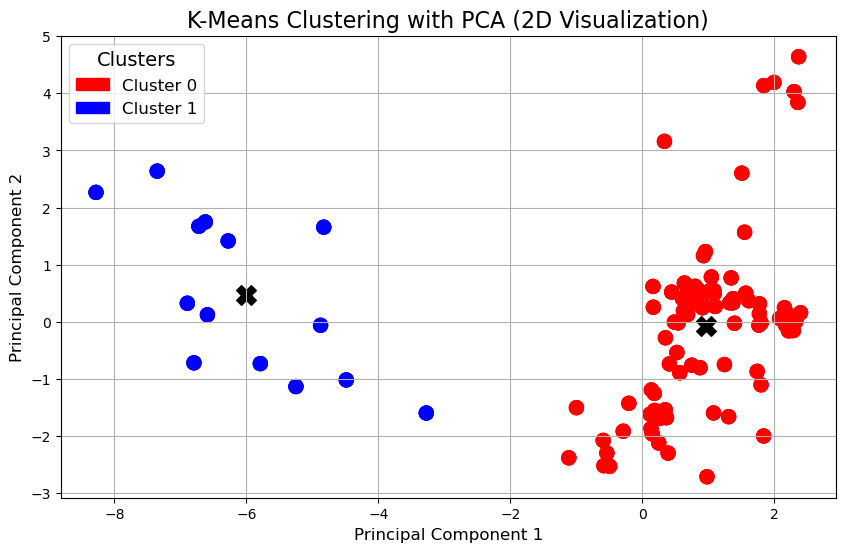

In [90]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


data = pd.read_csv("aggregated_node_metrics.csv")
df = pd.DataFrame(data)

df['is_outbound'] = df['is_outbound'].replace({True: 1, False: 0})

scaler = StandardScaler()
normalized_data = scaler.fit_transform(df.drop(columns=['Node_Moniker']))   

pca = PCA(n_components=2)  
reduced_data = pca.fit_transform(normalized_data)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(reduced_data)

df['Cluster'] = kmeans.labels_

cluster_colors = ['red', 'blue']
cmap = ListedColormap(cluster_colors)

plt.figure(figsize=(10, 6))
plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    c=df['Cluster'],
    cmap=cmap,
    s=100,
    alpha=0.7
)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    c='black',
    marker='X',
    s=200,
    label='Centroids'
)

plt.title("K-Means Clustering with PCA (2D Visualization)", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)

handles = [
    mpatches.Patch(color=cluster_colors[0], label='Cluster 0'),
    mpatches.Patch(color=cluster_colors[1], label='Cluster 1')

]

plt.legend(handles=handles, title='Clusters', fontsize=12, title_fontsize=14)
plt.grid(True)
plt.show()

